## Sequence to Sequence 구현
데이터를 직접 다루기보다는 차원 수를 확인하는 실습을 해보겠습니다. RNN 계통의 레이어들은 입력값과 반환값이 설정에 따라 각양각색입니다. 이번 구현에서는 입력으로 Embedding된 단어만 전달하고 (Hidden State는 전달하지 않습니다), 출력은 Encoder와 Decoder 별로 상이하므로 각각 설명을 첨부하겠습니다.

### LSTM Encoder

In [1]:
import tensorflow as tf

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(enc_units) # return_sequences 매개변수를 기본값 False로 전달

    def call(self, x):
        print("입력 Shape:", x.shape)

        x = self.embedding(x)
        print("Embedding Layer를 거친 Shape:", x.shape)

        output = self.lstm(x)
        print("LSTM Layer의 Output Shape:", output.shape)

        return output

Embedding 레이어를 단어 사이즈와 Embedding 차원에 대해 선언을 한 후, 논문에서 소개한 대로 tf.keras.layers.LSTM(enc_units)으로 LSTM을 정의합니다. TensorFlow 속 LSTM 모듈의 기본 반환 값은 최종 State 값이므로 return_sequences 나 return_state 값은 따로 조정하지 않습니다 (기본: False). 즉, 우리가 정의해 준 Encoder 클래스의 반환 값이 곧 컨텍스트 벡터(Context Vector) 가 됩니다.

In [2]:
vocab_size = 30000
emb_size = 256
lstm_size = 512
batch_size = 1
sample_seq_len = 3

print("Vocab Size:{0}".format(vocab_size))
print("Embedding Size:{0}".format(emb_size))
print("LSTM SizeL{0}".format(lstm_size))
print("Batch Size:{0}".format(batch_size))
print("Sample Sequence Length:{0}\n".format(sample_seq_len))

Vocab Size:30000
Embedding Size:256
LSTM SizeL512
Batch Size:1
Sample Sequence Length:3



In [3]:
encoder = Encoder(vocab_size, emb_size, lstm_size)
sample_input = tf.zeros((batch_size, sample_seq_len))

sample_output = encoder(sample_input) # 컨텍스트 벡터로 사용할 인코더 LSTM의 최종 State 값

입력 Shape: (1, 3)
Embedding Layer를 거친 Shape: (1, 3, 256)
LSTM Layer의 Output Shape: (1, 512)


In [4]:
tf.zeros((batch_size, sample_seq_len))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0., 0., 0.]], dtype=float32)>

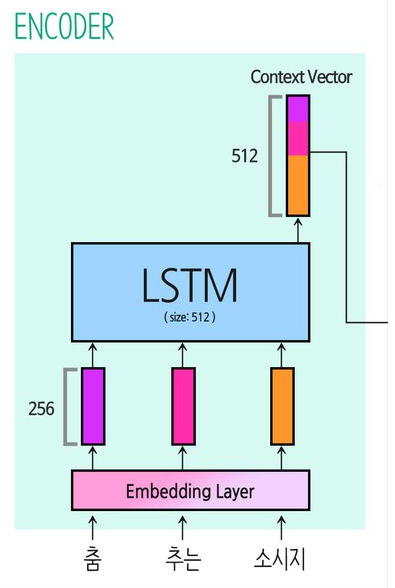

아주 간편하게 Encoder 클래스를 정의했습니다. 어떤 Source 문장을 Encoder에 읽히고, 그 반환 값인 LSTM의 최종 State 값을 Decoder에게 전달해 주면 되겠죠?

### LSTM Decoder

In [5]:
# Encoder 구현에 사용된 변수들을 이어 사용함에 주의!

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(dec_units,
                                     return_sequences=True) # return_sequences 매개변수를 True로 설정
        # Fully Connected, Softmax
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.softmax = tf.keras.layers.Softmax(axis=-1)

    def call(self, x, context_v):  # 디코더의 입력 x와 인코더의 컨텍스트 벡터를 인자로 받는다. 
        print("입력 Shape:", x.shape)

        x = self.embedding(x)
        print("Embedding Layer를 거친 Shape:", x.shape)

        context_v = tf.repeat(tf.expand_dims(context_v, axis=1),
                              repeats=x.shape[1], axis=1)
        x = tf.concat([x, context_v], axis=-1)  # 컨텍스트 벡터를 concat 해준다
        print("Context Vector가 더해진 Shape:", x.shape)

        x = self.lstm(x)
        print("LSTM Layer의 Output Shape:", x.shape)

        output = self.fc(x)
        print("Decoder 최종 Output Shape:", output.shape)

        return self.softmax(output)

Decoder는 Encoder와 구조적으로 유사하지만 결과물을 생성해야 하므로 Fully Connected 레이어가 추가되었고, 출력값을 확률로 변환해 주는 Softmax 함수도 추가되었습니다 (Softmax는 모델 내부에 포함시키지 않아도 훈련 과정에서 포함시키는 방법도 있습니다). 그리고 Decoder가 매 스텝 생성하는 출력은 우리가 원하는 번역 결과에 해당하므로 LSTM 레이어의 return_sequences 변수를 True로 설정하여 State 값이 아닌 Sequence 값을 출력으로 받습니다.

In [6]:
print("Vocab Size: {0}".format(vocab_size))
print("Embedidng Size: {0}".format(emb_size))
print("LSTM Size: {0}".format(lstm_size))
print("Batch Size: {0}".format(batch_size))
print("Sample Sequence Length: {0}\n".format(sample_seq_len))

Vocab Size: 30000
Embedidng Size: 256
LSTM Size: 512
Batch Size: 1
Sample Sequence Length: 3



In [7]:
decoder = Decoder(vocab_size, emb_size, lstm_size)
sample_input = tf.zeros((batch_size, sample_seq_len))

dec_output = decoder(sample_input, sample_output)  # Decoder.call(x, context_v) 을 호출

입력 Shape: (1, 3)
Embedding Layer를 거친 Shape: (1, 3, 256)
Context Vector가 더해진 Shape: (1, 3, 768)
LSTM Layer의 Output Shape: (1, 3, 512)
Decoder 최종 Output Shape: (1, 3, 30000)


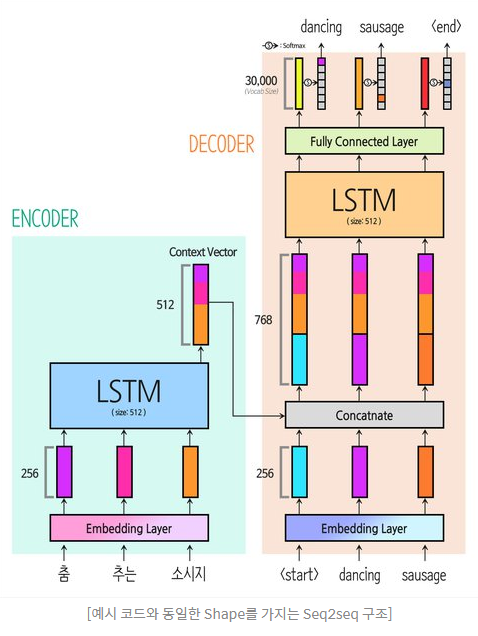

Encoder가 생성한 컨텍스트 벡터 v 를 Embedding 레이어를 거친 y 값에 Concatnate하여 위 수식을 비로소 만족하게 됩니다.

## Attention! (1) Bahdanau Attention
장점으로 보이는 어떤 것도 누군가에게는 결점이 보이는 법이죠. Bahdanau는 Seq2Seq의 컨텍스트 벡터가 고정된 길이로 정보를 압축하는 것이 손실을 야기한다고 주장하였습니다. 즉 짧은 문장에 대해서는 괜찮을지 모르겠으나 문장이 길어질수록 성능이 저하된다는 것이지요.  
이에 그는 Encoder의 최종 State 값만을 사용하는 기존의 방식이 아닌, 매 스텝의 Hidden State를 활용해 컨텍스트 벡터를 구축하는 Attention 메커니즘을 제안합니다.

### seq2seq과 attn-seq2seq, 뭐가 다른가?
Attention의 개념에 대해 어려워하는 분들이 많습니다. 이렇게 생각해 봅시다.  
Attention이 없는 것과 있는 것은 과연 뭐가 달라지는 것일까?  

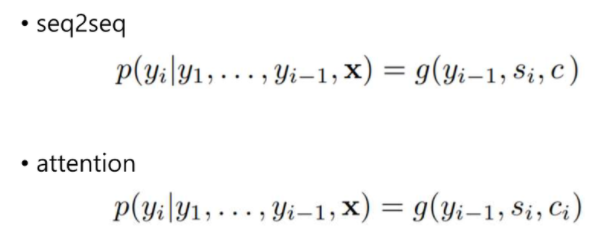

위의 두 식을 비교해 봅시다. Bahdanau 논문 원문에 나오는 Encoder-Decoder 구조에 대한 수식을 seq2seq만 있는 경우와 attention이 적용된 경우로 나누어 비교해 보면, 약간의 notation을 수정해서 보면 단 한 군데만 빼고는 사실상 동일합니다.  
  
유일한 차이는 attention이 있는 경우엔 바로 context vector cc에 첨자 ii가 붙어있다는 점입니다. 그렇다면 이 작은 첨자 하나가 어떤 근본적인 차이를 가져오게 되는 것인지 생각해 볼까요?  
여기서 유의해야 할 점은 i는 디코더의 인덱스, j는 인코더의 인덱스라는 점입니다.  
seq2seq의 인코더가 해석한 context는 디코더의 포지션 ii에 무관하게 항상 일정했습니다. 그러나 attention이 가미되면 달라집니다.

'나는 밥을 먹었다'라는 한글 문장을 'I ate lunch'로 번역한다고 생각해 봅시다. 영어 문장의 첫 번째(i=0) 단어 'I'를 만들어야 할 때 인코더가 한글 문장을 해석한 컨텍스트 벡터에서는 '나는'이 강조되어야 하고, 영어 문장의 세 번째(i=2) 단어 'lunch'를 만들어야 할 때 인코더의 컨텍스트 벡터에서는 '밥을'이 강조되어야 한다는 것입니다. 디코더가 현재 시점 ii에서 보기에 인코더의 어느 부분 jj가 중요한가? 이 가중치가 바로 attention인 것입니다.  
마나 강조되어야 하는지를 나타내는 가중치는 어떻게 계산하나요? 위의 식에서$\alpha_{ij}$가 바로 인코더의 $j$번째 hidden state $h_j$가 얼마나 강조되어야 할지를 결정하는 가중치 역할을 합니다. 이 가중치는 다시 디코더의 직전 스텝의 hidden state $s_{i-1}$와$h_j$의 유사도가 높을수록 높아지게 되어 있습니다.  
$\sum_{j} \alpha_{ij} = 1$

앞서 정의한 Score 함수를 구현해 보겠습니다.

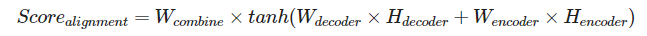

In [8]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W_decoder = tf.keras.layers.Dense(units)
        self.W_encoder = tf.keras.layers.Dense(units)
        self.W_combine = tf.kears.layers.Dense(1)
        
    def call(self, H_enoder, H_decoder):
        print("[H_encoder] Shape:", H_encoder.shape)
        
        print("\n[H_decoder] Shape", H_decoder.shape)
        H_decoder = tf.expand_dims(H_decoder, 1)
        H_decoder = self.W_decoder(H_decoder)
        
        print("[W_decoder X H_decoer] Shape:", H_decoder.shape)
        
        score = self.W_combine(tf.nn.tanh(H_decoder + H_encoder))
        print("[Score_alignment] Shape:", score.shape)
        
        attention_weights = tf.nn.softmax(score, axis=1)
        print("\n최종 Weight:\n", attention_weights.numpy())
        
        context_vector = attention_weights
        
        W_size = 100
        
        print("Hidden State를 {0} 차원으로 Mapping\n".format(W_size))
        
        attention = BahdanauAttention(W_size)
        
        enc_state = tf.random.uniform((1, 10, 512))
        dec_state = tf.random_uniform((1, 512))
        
        _ = attention(enc_state, dec_state)

Encoder의 모든 스텝에 대한 Hidden State를 100차원의 벡터 공간으로 매핑 (1, 10, 100) 하고, Decoder의 현재 스텝에 대한 Hidden State 역시 100차원의 벡터 공간으로 매핑 (1, 1, 100)해 두 State의 합으로 정의된 Score (1, 10, 1) 를 구했습니다.  
Softmax를 거쳐 나온 값은 0-1 사이의 값으로 각 단어가 차지하는 비중을 의미합니다. 랜덤한 값을 사용했기 때문에 비중이 비슷비슷하지만 실제 단어로 적용시켜보면 유사한 단어에 높은 비중을 할당하게 됩니다.

## Attention! (2) Luong Attention
Luong의 Attention은 Bahdanau의 방식을 약간 발전시킨 형태입니다. Decoder의 현재 Hidden State를 구하기 위해 한 스텝 이전의 Hidden State를 활용하는 것은 연산적으로 비효율적입니다. 이는 RNN의 연산 형태 때문입니다.  
일반적으로 여기에서 좋은 성능을 보이는 Score 함수는 General 이기에 이를 기반으로 구현해 보겠습니다.

In [9]:
class LuongAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(LuongAttention, self).__init__()
    self.W_combine = tf.keras.layers.Dense(units)

  def call(self, H_encoder, H_decoder):
    print("[ H_encoder ] Shape:", H_encoder.shape)

    WH = self.W_combine(H_encoder)
    print("[ W_encoder X H_encoder ] Shape:", WH.shape)

    H_decoder = tf.expand_dims(H_decoder, 1)
    alignment = tf.matmul(WH, tf.transpose(H_decoder, [0, 2, 1]))
    print("[ Score_alignment ] Shape:", alignment.shape)

    attention_weights = tf.nn.softmax(alignment, axis=1)
    print("\n최종 Weight:\n", attention_weights.numpy())

    attention_weights = tf.squeeze(attention_weights, axis=-1)
    context_vector = tf.matmul(attention_weights, H_encoder)

    return context_vector, attention_weights

emb_dim = 512

attention = LuongAttention(emb_dim)

enc_state = tf.random.uniform((1, 10, emb_dim))
dec_state = tf.random.uniform((1, emb_dim))

_ = attention(enc_state, dec_state)

[ H_encoder ] Shape: (1, 10, 512)
[ W_encoder X H_encoder ] Shape: (1, 10, 512)
[ Score_alignment ] Shape: (1, 10, 1)

최종 Weight:
 [[[7.3024734e-07]
  [9.6321473e-06]
  [2.7519304e-03]
  [1.8014504e-07]
  [9.4496290e-06]
  [4.4926819e-01]
  [5.2563399e-01]
  [9.8229259e-07]
  [1.3345452e-04]
  [2.2191485e-02]]]


Bahdanau의 Score 함수와는 다르게 하나의 Weight만을 사용하는 것이 특징입니다. 어떤 벡터 공간에 매핑해주는 과정이 없기 때문에 Weight의 크기는 단어 Embedding 크기와 동일해야 연산이 가능합니다. 